# **Subset CONUS and run ParFlow**
### This notebook has two principal sections: 
1. Subset all static inputs and climate forcings from a CONUS run stored in Hydrodata 
2. Load and alter a reference run to do a single or ensemble run of ParFlow-CLM

### Import the required libraries for step one (subsetting)

In [1]:
#import needed libraries to subset
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import os
from parflow import Run
from parflow.tools.io import read_pfb, write_pfb, read_clm, read_pfb_sequence
from parflow.tools.fs import cp, mkdir
from parflow.tools.settings import set_working_directory
from subsettools.subsettools import *
from subsettools.datasets import *
import pathlib
import shutil
import xarray as xr
import hydrodata.data_catalog.data_access
from pathlib import Path

### 1. Define variables to access datasets to subset in Hydrodata and define write paths

#### We will be testing with the Upper Verde watershed for this example
- HUC: 15060202
- Size: 6496 km^2 (ni = 112, nj = 90)   

#### Set your variables to specify which static and climate forcing data you would like to subset in Hydrodata

In [2]:
home = os.path.expanduser("~")
runname = "datacatalog_test1"
#provide a way to create a subset from the conus domain (huc, lat/lon bbox currently supported)
subset_target = "15060202"

#provide information about the datasets you want to access for run inputs using the data catalog
start = "2005-10-01" 
end = "2006-09-30"
grid = "conus1"  
run_ds = "conus1_baseline_mod"
var_ds = "conus1_domain"
forcing_ds = "NLDAS2"

#Set the directory paths where you want to write your subset files
static_write_dir = f"{home}/subsettools_tutorial/inputs/{runname}_{grid}_{end[:4]}WY/static/"
mkdir(static_write_dir) 
forcing_dir = f"{home}/subsettools_tutorial/inputs/{runname}_{grid}_{end[:4]}WY/forcing/"
mkdir(forcing_dir)

#setting up parflow run paths and run name
pf_out_dir = f"{home}/subsettools_tutorial/outputs/{runname}_{grid}_{end[:4]}WY/"
mkdir(pf_out_dir) 

#set PARFLOW_DIR path to the preferred version of ParFlow
os.environ["PARFLOW_DIR"] = "/home/SHARED/software/parflow/3.10.0"

reference_run = get_ref_yaml_path(grid, "transient", "solid")
target_runscript = pf_out_dir + runname + '.yaml'

### 2. Get the desired ParFlow x/y bbox from user provided geospatial information 

In [3]:
ij_bounds = get_conus_ij(domain = subset_target, grid = grid) #[imin, jmin, imax, jmax]
print(f'bounding box: {ij_bounds}')

nj = ij_bounds[3]-ij_bounds[1]
ni = ij_bounds[2]-ij_bounds[0]
print(f'nj: {nj}')
print(f'ni: {ni}')

bounding box: [375, 239, 487, 329]
nj: 90
ni: 112


/home/ga6/.conda/envs/subsettools/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'parflow' loading failed:
No module named 'dask'
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


### 3. Make the mask and solid file
You only do this if you provided a huc or a shapefile where we can extract a mask from the conus tif. Otherwise, the reference run is rewritten to provide a box domain.

In [4]:
create_mask_solid(huc_id = subset_target, grid = grid, write_dir = static_write_dir)

Provided HUC ID
grid is conus1
Wrote mask.pfb
Wrote solidfile.pfsol and mask_vtk.vtk with total z of 500 meters


### 4. Subset the static ParFlow inputs
Two options to subset static inputs. 
1. subset_static(): This function when provided with a variable dataset hosted on hydrodata will subset all static inputs required to do a baseline run from the default argument var_list without the user specify specific files. Pressure is the steady state pressure. If a user would like the override this, they may pass in their own value for var_list and their specifed variables in the target dataset will be subset. 

3. subset_press_init(): This function will write the subset pressure of the last hour in the last day before your start date. If no such pressure file exists in the hydrodata run dataset specifed, no file will be written. The function assumes UTC of zero as the default, but allows the user to override. 

In [5]:
subset_static(ij_bounds, dataset = var_ds, write_dir = static_write_dir)

Wrote slope_x.pfb in specified directory.
Wrote slope_y.pfb in specified directory.
Wrote pf_indicator.pfb in specified directory.
mannings not found in dataset conus1_domain
depth_to_bedrock not found in dataset conus1_domain
Wrote pme.pfb in specified directory.


In [6]:
subset_press_init(ij_bounds, dataset = run_ds, date = start, write_dir = static_write_dir, time_zone = 'UTC')
#subset_press_init(ij_bounds, dataset = run_ds, date = start, write_dir = static_write_dir, time_zone = 'America/New_York')
#subset_press_init(ij_bounds, dataset = run_ds, date = start, write_dir = static_write_dir, time_zone = 'US/Central')

Wrote conus1_baseline_mod_2005.09.30:23.00.00_UTC0_press.pfb in specified directory.


### 5. Configure CLM drivers
This function will get the clm drivers that are associated with your run dataset (same as data set as where you will get your initial pressure file). Vegm, vegp and drv_clmin will be written into your specified static input directory. 

In [7]:
config_clm(ij_bounds, start = start, end = end, dataset = run_ds, write_dir = static_write_dir)

vegp
/hydrodata/PFCLM/CONUS1_baseline/inputs/drv_vegp.dat
copied vegp
vegm
subsetting vegm (this takes awhile)
subset vegm
drv_clm
/hydrodata/PFCLM/CONUS1_baseline/run_scripts/CONUS_WY2003_2007_Cheyenne/drv_clmin.start.dat
edited drv_clmin


### 6. Subset the climate forcing

This function will write all variables needed to run CLM for your specified forcing dataset, on your specified grid, subset to the i/j boundary that was returned previously within the specified start and end date. 

In [8]:
subset_forcing(ij_bounds, grid = grid, start = start, end = end, dataset = forcing_ds, write_dir = forcing_dir)

Reading precipitation pfb sequence
Done reading precipitation pfb sequence, starting to write to folder
finished writing precipitation to folder
Reading downward_shortwave pfb sequence
Done reading downward_shortwave pfb sequence, starting to write to folder
finished writing downward_shortwave to folder
Reading downward_longwave pfb sequence
Done reading downward_longwave pfb sequence, starting to write to folder
finished writing downward_longwave to folder
Reading specific_humidity pfb sequence
Done reading specific_humidity pfb sequence, starting to write to folder
finished writing specific_humidity to folder
Reading air_temp pfb sequence
Done reading air_temp pfb sequence, starting to write to folder
finished writing air_temp to folder
Reading atmospheric_pressure pfb sequence
Done reading atmospheric_pressure pfb sequence, starting to write to folder
finished writing atmospheric_pressure to folder
Reading east_windspeed pfb sequence
Done reading east_windspeed pfb sequence, startin

### 7. Sanity check static and climate forcing by plotting (not an exhaustive check for accuracy)

#### Check static inputs

(5, 90, 112)


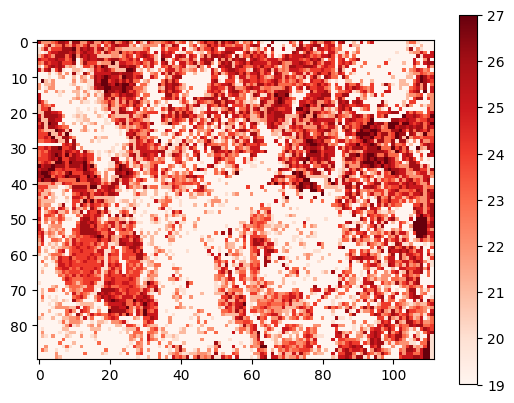

In [9]:
os.chdir(static_write_dir) 
test = read_pfb('pf_indicator.pfb')
print(test.shape)

cmap1='Reds'
sub_flip = np.zeros((1,nj,ni))
sub_flip[0,:,:] = test[0,:,:]
sub_flip = np.flip(sub_flip,1)

plt.imshow(sub_flip[0,:,:], cmap=cmap1)
plt.colorbar()

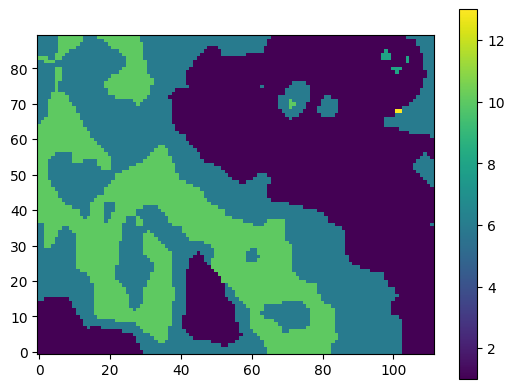

In [10]:
#checking vegm
os.chdir(static_write_dir) 
vegm = read_clm('/home/at8471/subset_pfensemble_wf/create_ensembles/inputs/datacatalog_test1_conus1_2006WY/static/drv_vegm.dat', type = 'vegm')

land_cover_vegm = np.zeros((vegm.shape[0], vegm.shape[1]))
mult = 0

for i in range(5,23):

    mult = mult + 1
    land_cover_vegm = land_cover_vegm + vegm[:,:,i] * mult

plt.imshow(land_cover_vegm, origin='lower', interpolation=None)

plt.colorbar()

#### Check climate forcing

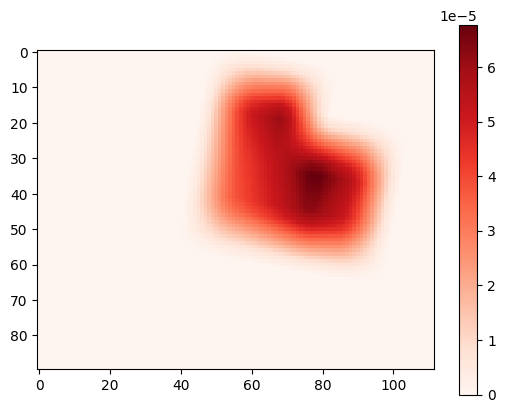

In [11]:
os.chdir(forcing_dir) 
test = read_pfb('NLDAS.APCP.003937_to_003960.pfb')
test = test.max(axis = 0) #so we can check a var like precip

sub_flip = np.zeros((1,nj,ni))
sub_flip[0,:,:] = test[:,:]
sub_flip = np.flip(sub_flip,1)
plt.imshow(sub_flip[0,:,:], cmap=cmap1)
plt.colorbar()

### 8. Set up a baseline run from a reference yaml
This function will return the correct template yaml file to do your run based on the grid, if you're doing spin-up and if you're using a solid file with the necessary keys changed to run your subset with selected climate forcing at baseline for one year

In [12]:
edit_runscript_for_subset(ij_bounds, runscript_path = reference_run, write_dir = pf_out_dir, runname = runname, forcing_dir = forcing_dir)

New runname: datacatalog_test1 provided, a new yaml file will be created
ComputationalGrid.NY set to 90 and NX to 112
Old path to climate forcing was  and has been changed to /home/ga6/subsettools_tutorial/inputs/datacatalog_test1_conus1_2006WY/forcing/ in runscript.
GeomInput.domaininput.InputType detected as SolidFile, no additional keys to change for subset
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/datacatalog_test1_conus1_2006WY/ as detected extension


### 9. Copy over your static files to your run directory
As a seperate function as you may only need to do this once, or you may want to copy subset static files to different run directories 

In [13]:
copy_static_files(static_input_dir = static_write_dir, pf_dir = pf_out_dir)

### 10. Change the file names in your runscript if desired
If you have changed the name of a static input file either from those used in the reference yamls provided on X GitHub repo, or have changed the name of an individual file for an ensemble or other experiment, you can change it with this function by providing the target runscript (yaml or pfidb) and the new file name(s) as an arguments. Only those arguments with a specified file name will be updated

In [14]:
change_filename_values(runscript_path = target_runscript, ip = "conus1_baseline_mod_2005.09.30:23.00.00_UTC0_press.pfb")

No write directory provided, updated or new yaml file will be written to the runscript path
Initial pressure filename changed to conus1_baseline_mod_2005.09.30:23.00.00_UTC0_press.pfb
Updated runscript written to /home/ga6/subsettools_tutorial/outputs/datacatalog_test1_conus1_2006WY as detected file extension


### 11. Change processor topolgoy if desired and then distribute your inputs and forcings to match the new topology

In [15]:
dist_run(P=4, Q=4, runscript_path = target_runscript, pf_run_dir = pf_out_dir, dist_clim_forcing = True)

Distributing your climate forcing
Distributed conus1_baseline_mod_2005.09.30:23.00.00_UTC0_press.pfb with NZ 5
Distributed mask.pfb with NZ 1
Distributed pf_indicator.pfb with NZ 5
Distributed pme.pfb with NZ 5
Distributed slope_x.pfb with NZ 1
Distributed slope_y.pfb with NZ 1
Distributed datacatalog_test1.out.perm_x.pfb with NZ 5
Distributed datacatalog_test1.out.perm_y.pfb with NZ 5
Distributed datacatalog_test1.out.perm_z.pfb with NZ 5
Distributed datacatalog_test1.out.porosity.pfb with NZ 5
Distributed datacatalog_test1.out.specific_storage.pfb with NZ 5
Distributed datacatalog_test1.out.alpha.pfb with NZ 5
Distributed datacatalog_test1.out.n.pfb with NZ 5
Distributed datacatalog_test1.out.sres.pfb with NZ 5
Distributed datacatalog_test1.out.ssat.pfb with NZ 5
Distributed datacatalog_test1.out.press.00000.pfb with NZ 5
Distributed datacatalog_test1.out.satur.00000.pfb with NZ 5
Distributed datacatalog_test1.out.mask.pfb with NZ 5
Distributed datacatalog_test1.out.press.00001.pfb w

### 12. Do a baseline run.
Load in the yaml run file you've created which is in the same folder as your static forcings and points to your desired Climate forcings. This assumes you do not want to make any changes from the parent model you used (Ex. conus1 baseline) and will run your subset at baseline conditions. Outputs should be almost identical to the parent model at your subset location for the same time period if you make no additional changes.

In [16]:
set_working_directory(f'{pf_out_dir}')
print(pf_out_dir)

#load the specified run script
run = Run.from_definition(target_runscript)
print(f"Loaded run with runname: {run.get_name()}")

# The following line is setting the run just for 10 hours for testing purposes
run.TimingInfo.StopTime = 10

#Need to set --ntasks='num_procs' (16 for 4x4) when starting notebook, request 1 core
run.run(working_directory=pf_out_dir)

/home/ga6/subsettools_tutorial/outputs/datacatalog_test1_conus1_2006WY/
Loaded run with runname: datacatalog_test1

# ==============================================================================
# ParFlow directory
#  - /home/SHARED/software/parflow/3.10.0
# ParFlow version
#  - 3.10.0
# Working directory
#  - /home/ga6/subsettools_tutorial/outputs/datacatalog_test1_conus1_2006WY
# ParFlow database
#  - datacatalog_test1.pfidb
# ==============================================================================


# ==============================================================================
# ParFlow ran successfully 💦 💦 💦 
# ==============================================================================



### 13. Restart a parflow run
If you need to restart a run to complete a spinup, transient run, etc then you can run the following to make the necessary updates to your runscript and then overwrite it in place

In [17]:
#restart_run(target_runscript)